In [7]:
# ============================================
# Heart Disease Prediction Model
# Digital Empowerment Network - AI Assignment 01
# ============================================

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (confusion_matrix, classification_report,
                            precision_score, recall_score, f1_score,
                            roc_curve, auc, precision_recall_curve)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [8]:
# ============================================
# Step A: Data Understanding & Preprocessing
# ============================================

# Load the dataset
try:
    df = pd.read_csv('heart_disease_uci.csv')
    print("Dataset loaded successfully!")

    # Initial exploration
    print("\n=== Dataset Info ===")
    print(df.info())
    print("\n=== First 5 Rows ===")
    print(df.head())

    # Data cleaning
    # Rename target column and drop unnecessary columns
    df = df.rename(columns={'num': 'disease_present'})
    df = df.drop(['id', 'dataset'], axis=1, errors='ignore')

    # Map values 1,2,3,4 to 1 (disease present)
    df['disease_present'] = df['disease_present'].map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})

    # Handle missing values
    print("\n=== Missing Values Before Treatment ===")
    print(df.isnull().sum())

    # For categorical features: fill with mode
    categorical_cols = ['restecg', 'fbs', 'exang', 'slope', 'thal']
    for col in categorical_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # For numerical features: fill with mean
    numerical_cols = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
    for col in numerical_cols:
        df[col].fillna(df[col].mean(), inplace=True)

    print("\n=== Missing Values After Treatment ===")
    print(df.isnull().sum())

    # Convert categorical variables to numerical
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    categorical_features = ['cp', 'restecg', 'slope', 'thal', 'fbs', 'exang', 'sex']
    for feature in categorical_features:
        df[feature] = label_encoder.fit_transform(df[feature])

except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure 'heart_disease_uci.csv' is in the correct directory.")
    exit()

Dataset loaded successfully!

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None

=== First 5 Rows ===
   id  age     sex    dataset               cp  tre

/tmp/ipython-input-8-1175110635.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-8-1175110635.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-8-1175110635.py:36: FutureW

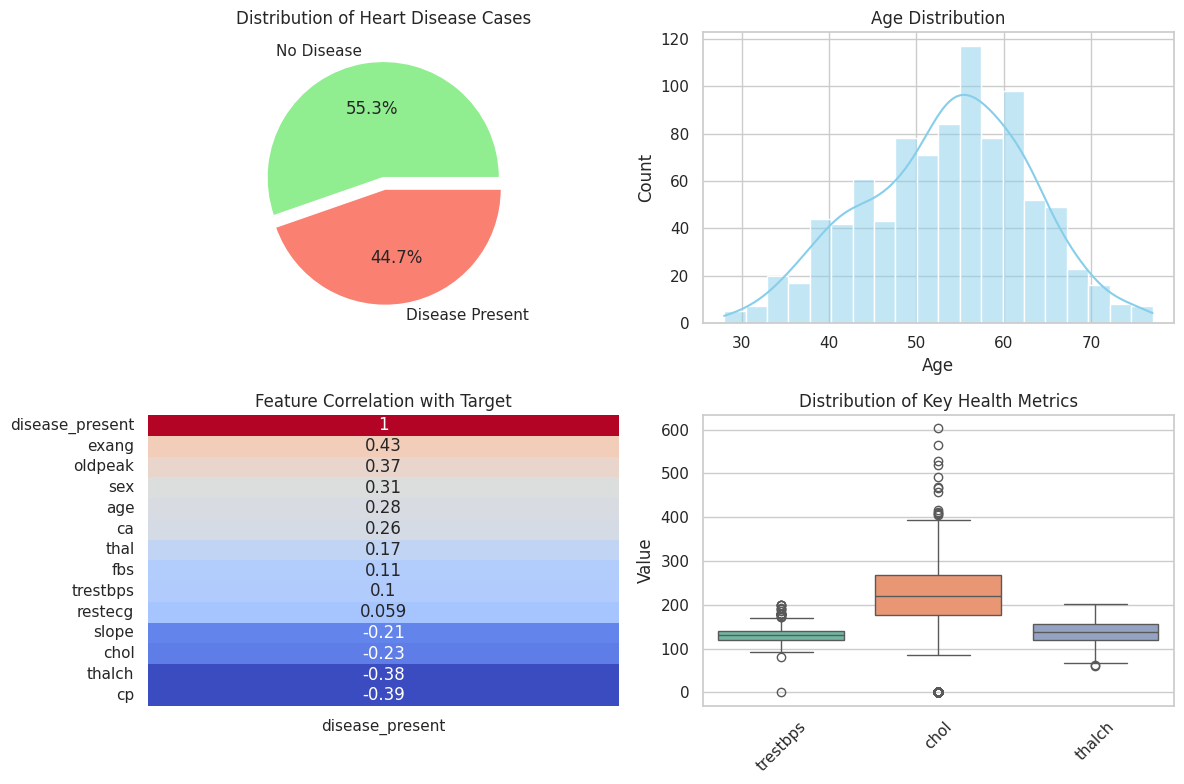


Generating pairplot (this may take a moment)...


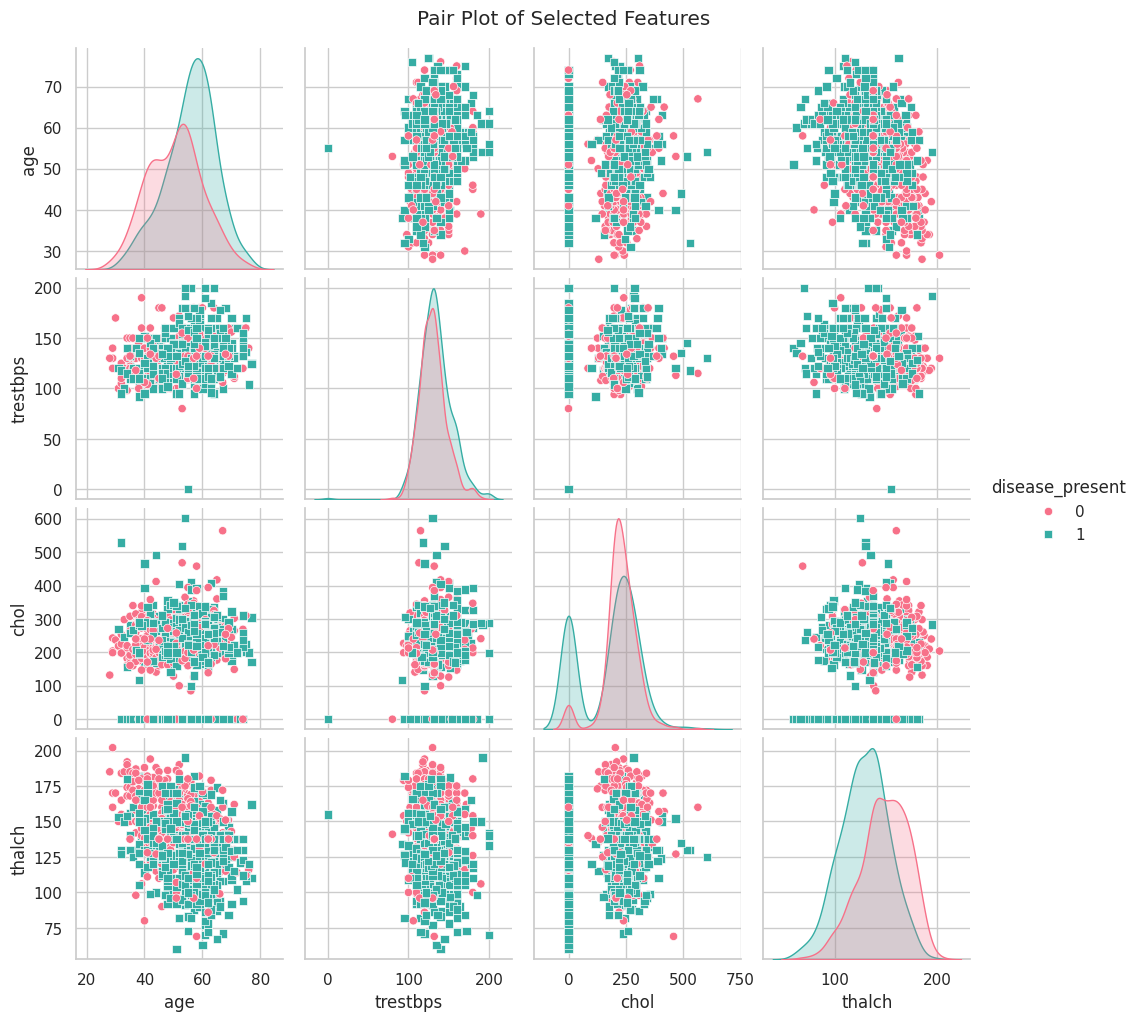

In [9]:
# ============================================
# Step B: Exploratory Data Analysis (EDA)
# ============================================

# Set style for plots
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# 1. Target variable distribution
plt.subplot(2, 2, 1)
target_counts = df['disease_present'].value_counts()
plt.pie(target_counts, labels=['No Disease', 'Disease Present'],
        autopct='%1.1f%%', colors=['lightgreen', 'salmon'], explode=[0, 0.1])
plt.title('Distribution of Heart Disease Cases')

# 2. Age distribution
plt.subplot(2, 2, 2)
sns.histplot(df['age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# 3. Correlation heatmap
plt.subplot(2, 2, 3)
corr_matrix = df.corr()
sns.heatmap(corr_matrix[['disease_present']].sort_values(by='disease_present', ascending=False),
            annot=True, cmap='coolwarm', cbar=False)
plt.title('Feature Correlation with Target')
plt.tight_layout()

# 4. Boxplot of key features
plt.subplot(2, 2, 4)
sns.boxplot(data=df[['trestbps', 'chol', 'thalch']], palette='Set2')
plt.title('Distribution of Key Health Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Additional EDA: Pairplot of selected features
print("\nGenerating pairplot (this may take a moment)...")
sns.pairplot(df[['age', 'trestbps', 'chol', 'thalch', 'disease_present']],
             hue='disease_present', palette='husl', markers=["o", "s"])
plt.suptitle("Pair Plot of Selected Features", y=1.02)
plt.show()

In [10]:
# ============================================
# Step C: Feature Selection
# ============================================

# Select features based on correlation
correlation_threshold = 0.1
correlated_features = corr_matrix['disease_present'][abs(corr_matrix['disease_present']) > correlation_threshold]
correlated_features = correlated_features.index.tolist()
correlated_features.remove('disease_present')

print("\nSelected Features based on Correlation:")
print(correlated_features)

# Prepare data for modeling
X = df[correlated_features]
y = df['disease_present']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Selected Features based on Correlation:
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']



=== Training Logistic Regression ===

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.69      0.80      0.74        75
           1       0.85      0.75      0.80       109

    accuracy                           0.77       184
   macro avg       0.77      0.78      0.77       184
weighted avg       0.78      0.77      0.77       184



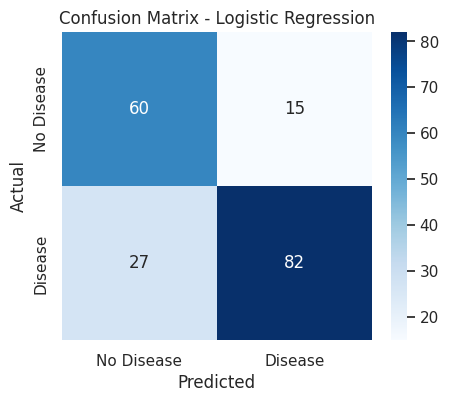


=== Training Support Vector Machine ===

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        75
           1       0.91      0.83      0.87       109

    accuracy                           0.85       184
   macro avg       0.84      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184



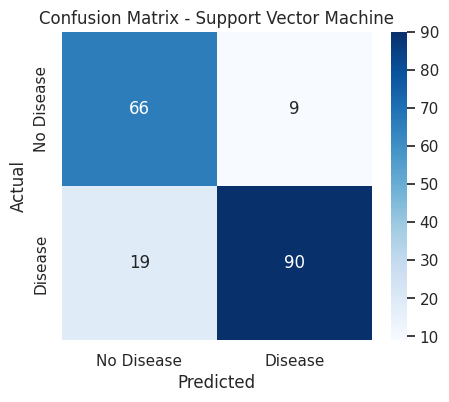


=== Training XGBoost ===

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        75
           1       0.91      0.82      0.86       109

    accuracy                           0.84       184
   macro avg       0.84      0.85      0.84       184
weighted avg       0.85      0.84      0.84       184



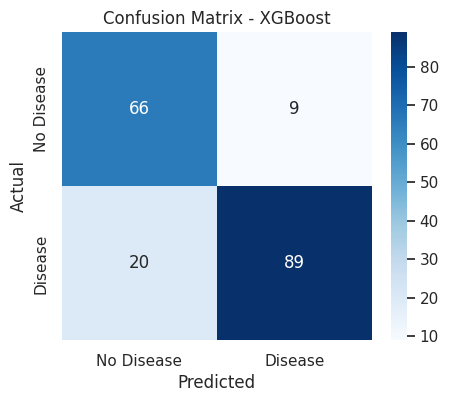


=== Training Random Forest ===

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        75
           1       0.90      0.82      0.86       109

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.84      0.84       184



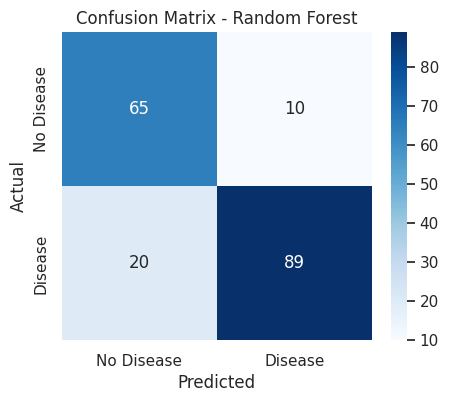

In [11]:
# ============================================
# Step D: Model Building & Evaluation
# ============================================

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(probability=True),
    "XGBoost": XGBClassifier(),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\n=== Training {name} ===")

    # Train model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for ROC curve

    # Calculate metrics
    accuracy = model.score(X_test_scaled, y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model,
        'y_prob': y_prob
    }

    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

<Figure size 1200x600 with 0 Axes>

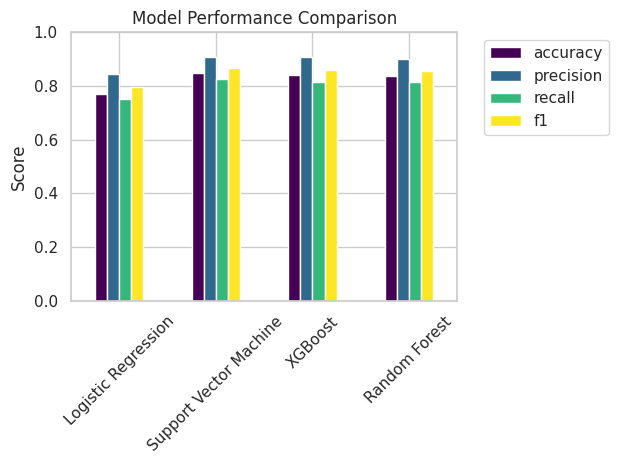

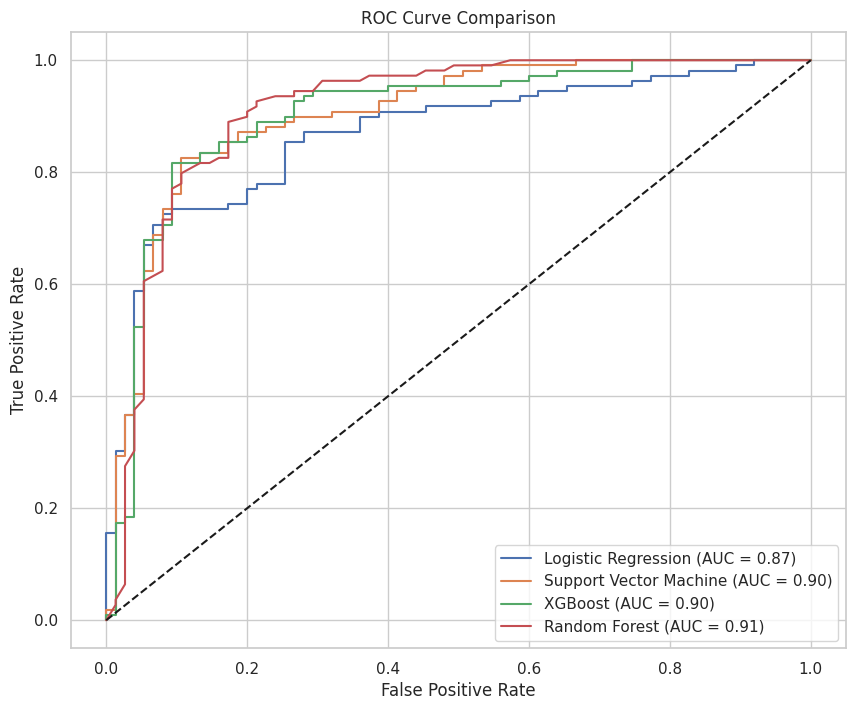

In [12]:
# ============================================
# Model Comparison
# ============================================

# Create comparison dataframe
comparison_df = pd.DataFrame.from_dict(results, orient='index')
comparison_df = comparison_df[['accuracy', 'precision', 'recall', 'f1']]

# Plot model performance comparison
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar', colormap='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ROC Curve comparison
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

In [13]:
# ============================================
# Step E: Optional - Hyperparameter Tuning
# ============================================

print("\n=== Hyperparameter Tuning for Best Model ===")

# Select best model based on accuracy
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"Selected best model for tuning: {best_model_name}")

if best_model_name == "Random Forest":
    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    }

    # Perform grid search
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)

    # Get best parameters and model
    best_params = grid_search.best_params_
    tuned_model = grid_search.best_estimator_

    print(f"\nBest Parameters: {best_params}")

    # Evaluate tuned model
    y_pred_tuned = tuned_model.predict(X_test_scaled)
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    print(f"\nTuned Model Accuracy: {accuracy_tuned:.4f}")
    print("\nClassification Report for Tuned Model:")
    print(classification_report(y_test, y_pred_tuned))


=== Hyperparameter Tuning for Best Model ===
Selected best model for tuning: Support Vector Machine


In [14]:
# ============================================
# Final Model Selection and Saving
# ============================================

# Select the best performing model
if 'tuned_model' in locals():
    final_model = tuned_model
else:
    final_model = results[best_model_name]['model']

# Save the final model
import joblib
joblib.dump(final_model, 'heart_disease_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nFinal model and scaler saved to disk.")


Final model and scaler saved to disk.


In [15]:

# ============================================
# Conclusion
# ============================================

print("\n=== Project Summary ===")
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.2%}")
print(f"Precision: {results[best_model_name]['precision']:.2%}")
print(f"Recall: {results[best_model_name]['recall']:.2%}")
print(f"F1 Score: {results[best_model_name]['f1']:.2%}")

print("\nProject completed successfully!")


=== Project Summary ===
Best Model: Support Vector Machine
Accuracy: 84.78%
Precision: 90.91%
Recall: 82.57%
F1 Score: 86.54%

Project completed successfully!
